# Sentiment Analysis
Here we use the tweets.csv file to perform sentiment analysis. The tweets.csv file contains the following columns:
- target: the polarity of the tweet (0 = negative, 4 = positive)
- ids: The id of the tweet ( 2087)
- date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- flag: The query (lyx). If there is no query, then this value is NO_QUERY.
- user: the user that tweeted (robotickilldozr)
- text: the text of the tweet (Lyx is cool)

In [0]:
# importing dependencies
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

enable_grid = True

In [0]:
# read tweets.csv file into spark dataframe
tweets_df = spark.read.csv("dbfs:/FileStore/tables/tweets.csv", header=True, inferSchema=True)
tweets_df.show(5)

+------+----------+--------------------+--------+-----------+--------------------+
target| id| date| flag| user| text|
+------+----------+--------------------+--------+-----------+--------------------+
 4|1467822272|Mon Apr 06 22:22:...|NO_QUERY| ersle|I LOVE @Health4Ua...|
 4|1467822273|Mon Apr 06 22:22:...|NO_QUERY| becca210|im meeting up wit...|
 4|1467822283|Mon Apr 06 22:22:...|NO_QUERY| Wingman29|@DaRealSunisaKim ...|
 4|1467822287|Mon Apr 06 22:22:...|NO_QUERY| katarinka|Being sick can be...|
 4|1467822293|Mon Apr 06 22:22:...|NO_QUERY|_EmilyYoung|@LovesBrooklyn2 h...|
+------+----------+--------------------+--------+-----------+--------------------+
only showing top 5 rows

##### Data Cleaning 
We drop all columns except target and text.  Transform the target column such that a negative sentiment is equal to 0 and a positive sentiment is equal to 1 and then print the percentage of positive and negative tweets in the dataframe such that it's easy to interpret our data.

In [0]:
import pyspark.sql.functions as F

tweets_df = tweets_df.drop('id','date','flag','user')

tot = tweets_df.count()

tweets_df.groupBy('target') \
         .count() \
         .withColumn('perc_of_count_total', (F.col('count') / tot) * 100 ) \
         .show()

+------+-----+-------------------+
target|count|perc_of_count_total|
+------+-----+-------------------+
 4|50000| 50.0|
 0|50000| 50.0|
+------+-----+-------------------+

In [0]:
display(tweets_df.toPandas().head())

target,text
4,I LOVE @Health4UandPets u guys r the best!!
4,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!
4,"@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart."
4,"Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup"
4,@LovesBrooklyn2 he has that effect on everyone


In [0]:
import pyspark.sql.functions as F

tweets_df = tweets_df.withColumn("target", \
              F.when(tweets_df["target"] == 4, 1).otherwise(tweets_df["target"]))

tot = tweets_df.count()

tweets_df.groupBy('target') \
         .count() \
         .withColumn('perc_of_count_total', (F.col('count') / tot) * 100 ) \
         .show()

+------+-----+-------------------+
target|count|perc_of_count_total|
+------+-----+-------------------+
 1|50000| 50.0|
 0|50000| 50.0|
+------+-----+-------------------+

In [0]:
tweets_pd = tweets_df.toPandas()
display(tweets_pd.head())
print(tweets_pd.shape)

target,text
1,I LOVE @Health4UandPets u guys r the best!!
1,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!
1,"@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart."
1,"Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup"
1,@LovesBrooklyn2 he has that effect on everyone


(100000, 2)

###### Data Preprocessing
We create a pipeline named `tweets_pre_proc_pipe`. This pipeline tokenizes, removes stop words, and does a TF-IDF transformation.  Then we fit and execute our pipeline, and create a new dataframe named `tweets_pre_proc_df`.

In [0]:
#import RegexTokenizer
from pyspark.ml.feature import RegexTokenizer

In [0]:
# create the tokenizer object
tokenizer = RegexTokenizer().setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("text")\
  .setOutputCol("words")

#tokenize the text by transforming df
tokenizer.transform(tweets_df).show()

+------+--------------------+--------------------+
target| text| words|
+------+--------------------+--------------------+
 1|I LOVE @Health4Ua...|[i, love, health,...|
 1|im meeting up wit...|[im, meeting, up,...|
 1|@DaRealSunisaKim ...|[darealsunisakim,...|
 1|Being sick can be...|[being, sick, can...|
 1|@LovesBrooklyn2 h...|[lovesbrooklyn, h...|
 1|@ProductOfFear Yo...|[productoffear, y...|
 1|@r_keith_hill Tha...|[r, keith, hill, ...|
 1|@KeepinUpWKris I ...|[keepinupwkris, i...|
 1|@tommcfly ah, con...|[tommcfly, ah, co...|
 1|@e4VoIP I RESPOND...|[e, voip, i, resp...|
 1|crazy day of scho...|[crazy, day, of, ...|
 1|@naughtyhaughty H...|[naughtyhaughty, ...|
 1|@nileyjileyluver ...|[nileyjileyluver,...|
 1|@soundwav2010 At ...|[soundwav, at, le...|
 1|@LutheranLucciol ...|[lutheranlucciol,...|
 1|Just added tweeti...|[just, added, twe...|
 1|@michellardi i re...|[michellardi, i, ...|
 1|@nicolerichie: yo...|[nicolerichie, yo...|
 1|Catching Up on Em...|[catching, up, on...|
 1|Dancing around th...|[dancing, around,...|
+------+--------------------+--------------------+
only showing top 20 rows

In [0]:
import requests

#fetch stopwords from a website
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
stop_words[0:10]

Out[30]: ['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost']

In [0]:
from pyspark.ml.feature import StopWordsRemover

#create stop words remover object
sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

In [0]:
from pyspark.ml import Pipeline

#create transformer to tokenize, remove stopwords
sw_pipe = Pipeline(stages=[tokenizer, sw_filter]).fit(tweets_df)
sw_pipe.transform(tweets_df).show(5)

+------+--------------------+--------------------+--------------------+
target| text| words| filtered|
+------+--------------------+--------------------+--------------------+
 1|I LOVE @Health4Ua...|[i, love, health,...|[love, health, ua...|
 1|im meeting up wit...|[im, meeting, up,...|[im, meeting, bes...|
 1|@DaRealSunisaKim ...|[darealsunisakim,...|[darealsunisakim,...|
 1|Being sick can be...|[being, sick, can...|[sick, really, ch...|
 1|@LovesBrooklyn2 h...|[lovesbrooklyn, h...|[lovesbrooklyn, e...|
+------+--------------------+--------------------+--------------------+
only showing top 5 rows

In [0]:
from pyspark.ml.feature import CountVectorizer

#count vectorizer object
cv = CountVectorizer(minTF=1., minDF=5., vocabSize=2**17)\
  .setInputCol("filtered")\
  .setOutputCol("tf")

In [0]:
#count vectorizer transformer
cv_pipe = Pipeline(stages=[sw_pipe,cv]).fit(tweets_df)
cv_pipe.transform(tweets_df).show(5)

+------+--------------------+--------------------+--------------------+--------------------+
target| text| words| filtered| tf|
+------+--------------------+--------------------+--------------------+--------------------+
 1|I LOVE @Health4Ua...|[i, love, health,...|[love, health, ua...|(11099,[14,21,87,...|
 1|im meeting up wit...|[im, meeting, up,...|[im, meeting, bes...|(11099,[20,58,66,...|
 1|@DaRealSunisaKim ...|[darealsunisakim,...|[darealsunisakim,...|(11099,[12,25,29,...|
 1|Being sick can be...|[being, sick, can...|[sick, really, ch...|(11099,[18,56,80,...|
 1|@LovesBrooklyn2 h...|[lovesbrooklyn, h...|[lovesbrooklyn, e...|(11099,[2090],[1.0])|
+------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows

In [0]:
from pyspark.ml.feature import IDF

#create idf object
idf = IDF().\
    setInputCol('tf').\
    setOutputCol('tfidf')

In [0]:
idf_pipe = Pipeline(stages=[cv_pipe,idf]).fit(tweets_df)
idf_pipe.transform(tweets_df).show(5)

+------+--------------------+--------------------+--------------------+--------------------+--------------------+
target| text| words| filtered| tf| tfidf|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+
 1|I LOVE @Health4Ua...|[i, love, health,...|[love, health, ua...|(11099,[14,21,87,...|(11099,[14,21,87,...|
 1|im meeting up wit...|[im, meeting, up,...|[im, meeting, bes...|(11099,[20,58,66,...|(11099,[20,58,66,...|
 1|@DaRealSunisaKim ...|[darealsunisakim,...|[darealsunisakim,...|(11099,[12,25,29,...|(11099,[12,25,29,...|
 1|Being sick can be...|[being, sick, can...|[sick, really, ch...|(11099,[18,56,80,...|(11099,[18,56,80,...|
 1|@LovesBrooklyn2 h...|[lovesbrooklyn, h...|[lovesbrooklyn, e...|(11099,[2090],[1.0])|(11099,[2090],[7....|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows

In [0]:
from pyspark.ml import Pipeline
tweets_pre_proc_pipe = Pipeline(stages=[tokenizer, sw_filter,cv, idf]).fit(tweets_df)
tweets_pre_proc_df = tweets_pre_proc_pipe.transform(tweets_df)
tweets_pre_proc_df.show(5)

+------+--------------------+--------------------+--------------------+--------------------+--------------------+
target| text| words| filtered| tf| tfidf|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+
 1|I LOVE @Health4Ua...|[i, love, health,...|[love, health, ua...|(11099,[14,21,87,...|(11099,[14,21,87,...|
 1|im meeting up wit...|[im, meeting, up,...|[im, meeting, bes...|(11099,[20,58,66,...|(11099,[20,58,66,...|
 1|@DaRealSunisaKim ...|[darealsunisakim,...|[darealsunisakim,...|(11099,[12,25,29,...|(11099,[12,25,29,...|
 1|Being sick can be...|[being, sick, can...|[sick, really, ch...|(11099,[18,56,80,...|(11099,[18,56,80,...|
 1|@LovesBrooklyn2 h...|[lovesbrooklyn, h...|[lovesbrooklyn, e...|(11099,[2090],[1.0])|(11099,[2090],[7....|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows

In [0]:
#number of words
len(tweets_pre_proc_pipe.stages[-2].vocabulary)

Out[38]: 11099

In [0]:
#number of records
tweets_pre_proc_df.count()

Out[39]: 100000

In [0]:
display(tweets_pre_proc_df.toPandas().head())

/databricks/spark/python/pyspark/sql/pandas/conversion.py:300: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Could not convert (11099,[14,21,87,118,157,1549],[1.0,1.0,1.0,1.0,1.0,1.0]) with type SparseVector: did not recognize Python value type when inferring an Arrow data type
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)

target,text,words,filtered,tf,tfidf
1,I LOVE @Health4UandPets u guys r the best!!,"List(i, love, health, uandpets, u, guys, r, the, best)","List(love, health, uandpets, u, guys, r, best)","Map(vectorType -> sparse, length -> 11099, indices -> List(14, 21, 87, 118, 157, 1549), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0))","Map(vectorType -> sparse, length -> 11099, indices -> List(14, 21, 87, 118, 157, 1549), values -> List(3.3607374490584423, 3.7017720798949503, 4.628448812877446, 4.892862258389872, 5.096203182407903, 7.452492454373809))"
1,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!,"List(im, meeting, up, with, one, of, my, besties, tonight, cant, wait, girl, talk)","List(im, meeting, besties, tonight, wait, girl, talk)","Map(vectorType -> sparse, length -> 11099, indices -> List(20, 58, 66, 155, 213, 456, 5730), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))","Map(vectorType -> sparse, length -> 11099, indices -> List(20, 58, 66, 155, 213, 456, 5730), values -> List(3.589587252990074, 4.258757618463711, 4.395729961755885, 5.067215645534651, 5.298327366498037, 6.05334995077607, 9.02802881513223))"
1,"@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart.","List(darealsunisakim, thanks, for, the, twitter, add, sunisa, i, got, to, meet, you, once, at, a, hin, show, here, in, the, dc, area, and, you, were, a, sweetheart)","List(darealsunisakim, thanks, twitter, add, sunisa, got, meet, hin, dc, area, sweetheart)","Map(vectorType -> sparse, length -> 11099, indices -> List(12, 25, 29, 306, 517, 1232, 1459, 3396), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))","Map(vectorType -> sparse, length -> 11099, indices -> List(12, 25, 29, 306, 517, 1232, 1459, 3396), values -> List(3.315121432699027, 3.669479060544113, 3.705425422704036, 5.655002310436769, 6.17539738521891, 7.182202124633897, 7.354052381560557, 8.37744124899108))"
1,"Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup","List(being, sick, can, be, really, cheap, when, it, hurts, too, much, to, eat, real, food, plus, your, friends, make, you, soup)","List(sick, really, cheap, hurts, eat, real, food, plus, friends, make, soup)","Map(vectorType -> sparse, length -> 11099, indices -> List(18, 56, 80, 101, 229, 235, 236, 242, 685, 1117, 1696), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))","Map(vectorType -> sparse, length -> 11099, indices -> List(18, 56, 80, 101, 229, 235, 236, 242, 685, 1117, 1696), values -> List(3.5466956883607614, 4.2260590531695295, 4.58048757334772, 4.7444422532715995, 5.375208410833995, 5.430716554543783, 5.451478545992212, 5.428436051845058, 6.489054944073953, 7.094094857123631, 7.523951418355955))"
1,@LovesBrooklyn2 he has that effect on everyone,"List(lovesbrooklyn, he, has, that, effect, on, everyone)","List(lovesbrooklyn, effect)","Map(vectorType -> sparse, length -> 11099, indices -> List(2090), values -> List(1.0))","Map(vectorType -> sparse, length -> 11099, indices -> List(2090), values -> List(7.77526584663686))"


If the number of features are more than number of observations, then there is a high chance that our model will overfit over the data. High number of variables will give us high accuracy for training data, as it will always fit the best model, but the generalization error will be high on testing data. In this case, number of observations is 100000 and number of columns is 13296. Hence, the model will most likely not overfit over the data.

In [0]:
import pandas as pd
vocabulary = idf_pipe.stages[0].stages[-1].vocabulary
tfidf_val = idf_pipe.stages[-1].idf

print("num idf values:", len(tfidf_val))
print("num rows:", tweets_df.count())

idf_df = pd.DataFrame({'word': vocabulary, 'idf_score': tfidf_val})
idf_df.head()

num idf values: 11099
num rows: 100000
Out[41]:

,word,idf_score
0,s,2.247728
1,t,2.232416
2,m,2.549391
3,just,2.568907
4,good,2.873348


In [0]:
least_imp_idf = idf_df.sort_values('idf_score').head(5)
display(least_imp_idf)

word,idf_score
t,2.2324162583227993
s,2.247728191503206
m,2.5493911729234844
just,2.5689071396596344
good,2.8733476652903853


In [0]:
most_imp_idf = idf_df.sort_values('idf_score', ascending=False).head(5)
display(most_imp_idf)

word,idf_score
sniffling,9.721175995692173
hurtful,9.721175995692173
limburger,9.721175995692173
prejudice,9.721175995692173
vey,9.721175995692173


##### Inference 

Since IDF considers a word's frequency across all documents in a corpus, we can use IDF as a form of inference. 
The inverse document frequency of the word across a set of documents. This means, how common or rare a word is in the entire 
document set. The closer it is to 0, the more common a word is. This metric can be calculated by taking the total number of documents, 
dividing it by the number of documents that contain a word, and calculating the logarithm.
So, if the word is very common and appears in many documents, this number will approach 0.

##### Logistic Regression
We create a new recursive pipeline named `lr_pipe` which starts with `tweets_pre_proc_pipe` and add a logistic regression model using default hyper parameters. Then we Fit lr_pipe using `tweets_df`.  
We score the model using ROC AUC.

In [0]:
#split the data into training, validation, and testing
training_df, validation_df,testing_df = tweets_df.randomSplit([0.6, 0.3, 0.1], seed=0)
training_df.toPandas().head()

Out[44]:

,target,text
0,1,my friends can get with ur friends and we c...
1,1,uploading pictures on friendster
2,1,we break dance not hearts by Short Stack is...
3,1,&quot;I'm a freelance writer for Braille porn...
4,1,- Iowa No. 2 in happy! Yea!


In [0]:
# your code here
from pyspark.ml.classification import LogisticRegression

#logistic regression object
lr = LogisticRegression().\
    setLabelCol('target').\
    setFeaturesCol('tfidf')

In [0]:
#logistic regression pipeline
lr_pipe = Pipeline(stages=[tweets_pre_proc_pipe, lr]).fit(training_df)
lr_df = lr_pipe.transform(validation_df)
lr_df.show(5)

+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
target| text| words| filtered| tf| tfidf| rawPrediction| probability|prediction|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
 1| man, oh man ...|[man, oh, man, i,...|[man, oh, man, pu...|(11099,[20,30,89,...|(11099,[20,30,89,...|[0.50587258215311...|[0.62383841407378...| 0.0|
 1| I'm really goin...|[i, m, really, go...|[m, really, going...|(11099,[2,10,18,4...|(11099,[2,10,18,4...|[0.26465368720009...|[0.56577992512944...| 0.0|
 1| @3sixty5days mak...|[sixty, days, mak...|[days, makes, smile]|(11099,[67,179,56...|(11099,[67,179,56...|[-1.9133520473455...|[0.12860473520361...| 1.0|
 1| @unholyhole @bur...|[unholyhole, burn...|[unholyhole, burn...|(11099,[11,20,388...|(11099,[11,20,388...|[-15.502453012504...|[1.85084529947403...| 1.0|
 1| Going to london ...|[going, to, londo...|[going, london, d...|(11099,[10,67,291...|(11099,[10,67,291...|[-1.0941540186221...|[0.25083685698109...| 1.0|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows

In [0]:
#calculate accuracy
lr_pipe.transform(validation_df).\
    select(F.expr('float(prediction = target)').alias('correct')).\
    select(F.avg('correct')).show()

+------------------+
 avg(correct)|
+------------------+
0.7131021580811118|
+------------------+

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# use the evaluator
evaluator = BinaryClassificationEvaluator(labelCol='target')

# fetch auc value
auroc = evaluator.evaluate(lr_df, {evaluator.metricName: "areaUnderROC"})

print("Area under ROC Curve: {:.4f}".format(auroc))

Area under ROC Curve: 0.7511

In [0]:
import pandas as pd

#fetch words and lr coefficients
vocabulary = idf_pipe.stages[0].stages[-1].vocabulary
weights = lr_pipe.stages[-1].coefficients.toArray()
print("num weights:", len(weights))
print("num rows:", validation_df.count())

coeffs_df = pd.DataFrame({'word': vocabulary, 'score': weights})
coeffs_df.head()

num weights: 11099
num rows: 29934
Out[49]:

,word,score
0,s,-0.023179
1,t,-0.539184
2,m,-0.060192
3,just,0.045290
4,good,0.371771


In [0]:
lr_pipe_df_neg = coeffs_df.sort_values('score').head(10)
display(lr_pipe_df_neg)

word,score
sketch,-7.882860868598902
makin,-5.899915970343987
ceo,-5.031845247338035
roadshow,-4.686733399257193
creme,-4.610290560230335
sporting,-4.3950674827072085
pwn,-4.11568632602655
depeche,-4.05815955144604
port,-4.057052692880827
compliments,-3.811875915492047


In [0]:
lr_pipe_df_pos = coeffs_df.sort_values('score', ascending=False).head(10)
display(lr_pipe_df_pos)

word,score
cox,6.032019390066858
driveway,5.980353084866993
insult,4.932508751912497
businesses,4.727690223708115
hansonmusic,4.64602761981971
handshake,4.571280293819759
depending,4.030027784224961
shanedawson,3.9942455585622043
tj,3.9436043542403674
payment,3.8945194643794303


The words do not make sense. Words are not truly negative or positive. Most of them look very random. We now perform a grid search to find optimized parameters and improve accuracy.

##### Grid Search
The goal is to try to improve the score using a regularization grid search on a new pipeline named `lr_pipe_1`. lr_pipe_1 is the same as lr_pipe above.

In [0]:
# grid search (and only your grid search) code
if enable_grid:
    from pyspark.ml.tuning import ParamGridBuilder
    import numpy as np
    #lr_pipe_1 same as lr_pipe pipeline and transformer
    lr_pipe_1_est = Pipeline(stages=[tokenizer, sw_filter,cv, idf, lr])
    lr_pipe_1 = lr_pipe_1_est.fit(training_df)

    #get accuracy
    lr_pipe_1.transform(validation_df).\
      select(F.expr('float(prediction = target)').alias('correct')).\
      select(F.avg('correct')).show()

    #create grid to get combination of parameters
    grid = ParamGridBuilder().\
    addGrid(lr.regParam, [0., 0.01, 0.02]).\
    addGrid(lr.elasticNetParam, [0., 0.2, 0.4]).\
    build()

    #iterate through the grid
    all_models = []
    for j in range(len(grid)):
      print("Fitting model {}".format(j+1))
      model = lr_pipe_1_est.fit(training_df, grid[j])
      all_models.append(model)

    #calculate accuracies of all models
    accuracies = [m.\
    transform(validation_df).\
    select(F.avg(F.expr('float(target = prediction)')).alias('accuracy')).\
    first().\
    accuracy for m in all_models]

    #get best model index
    best_model_idx = np.argmax(accuracies)
    print("best model index = ", best_model_idx)

    print(grid[best_model_idx])

    best_model = all_models[best_model_idx]
    print("accuracy of best model=", accuracies[best_model_idx])

    # estimate generalization performance
    best_model.transform(testing_df).\
      select(F.expr('float(prediction = target)').alias('correct')).\
      select(F.avg('correct')).show()

    pass

+------------------+
 avg(correct)|
+------------------+
0.7348834101690386|
+------------------+

Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8
Fitting model 9
best model index = 4
{Param(parent='LogisticRegression_e207998108fa', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_e207998108fa', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.2}
accuracy of best model= 0.7552281686376695
+------------------+
 avg(correct)|
+------------------+
0.7557114228456914|
+------------------+

In [0]:
# optimized model code here
alpha = 0.2
lambda_val = 0.01

# lr_pipe_2 code here
lr2 = LogisticRegression().\
    setLabelCol('target').\
    setFeaturesCol('tfidf').\
    setRegParam(lambda_val).\
    setMaxIter(100).\
    setElasticNetParam(alpha)

lr_pipe_2 = Pipeline(stages=[tokenizer, sw_filter,cv, idf, lr2]).fit(training_df)
lr_df2 = lr_pipe_2.transform(validation_df)

lr_pipe_2.transform(validation_df).\
    select(F.expr('float(prediction = target)').alias('correct')).\
    select(F.avg('correct')).show()

+------------------+
 avg(correct)|
+------------------+
0.7552281686376695|
+------------------+

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Let's use the run-of-the-mill evaluator
evaluator2 = BinaryClassificationEvaluator(labelCol='target')

# We have only two choices: area under ROC and PR curves :-(
auroc2 = evaluator2.evaluate(lr_df2, {evaluator.metricName: "areaUnderROC"})

print("Area under ROC Curve: {:.4f}".format(auroc2))

Area under ROC Curve: 0.8284

In [0]:
import pandas as pd
model_names = ['lr_pipe','lr_pipe_2']
auc_scores = [auroc,auroc2]

compare_1_df = pd.DataFrame({'model_name': model_names, 'auc_score': auc_scores})
display(compare_1_df)

model_name,auc_score
lr_pipe,0.7511298466288837
lr_pipe_2,0.8284427968466164


In [0]:
import pandas as pd
vocabulary = lr_pipe_2.stages[-3].vocabulary
weights = lr_pipe_2.stages[-1].coefficients.toArray()
print("num weights:", len(weights))
print("num rows:", validation_df.count())

coeffs_df2 = pd.DataFrame({'word': vocabulary, 'score': weights})
coeffs_df2.head()

num weights: 7755
num rows: 29934
Out[65]:

,word,score
0,s,0.000000
1,t,-0.271278
2,m,-0.027651
3,just,0.013817
4,good,0.232894


In [0]:
print("Words eliminated in first model : ", (coeffs_df['score'] == 0.0).sum())

Words eliminated in first model : 16

In [0]:
print("Words eliminated in optimized model : ", (coeffs_df2['score'] == 0.0).sum())

Words eliminated in optimized model : 4811

In [0]:
# your code here
lr_pipe_df_neg_1 = coeffs_df2.sort_values('score').head(10)
display(lr_pipe_df_neg_1)

word,score
sad,-0.5272540790337289
miss,-0.3827995860382603
sadly,-0.3772368989421874
missing,-0.3675824840156516
sick,-0.34516921759589597
poor,-0.344068683730088
wish,-0.3394872870620077
sucks,-0.310807284629434
hurts,-0.3094193418862258
hates,-0.30304256782044336


In [0]:
lr_pipe_df_pos_1 = coeffs_df2.sort_values('score', ascending=False).head(10)
display(lr_pipe_df_pos_1)

word,score
thanks,0.35309684005181224
welcome,0.3229225242444004
thank,0.2701664818285908
congratulations,0.2474112689798899
great,0.24251564977295387
good,0.23289414743235473
proud,0.230587000490349
happy,0.22771183178250706
love,0.2221546005889984
glad,0.21337768118873102


##### Inference on new positive and negative words outcome :

Earlier the positive and negative words did not make sense. But in this case we can see the positive words are actually positive and negative words are actually negative in proper order.

##### Data Visualization
We create a receiver operating characteristic (ROC) plot for the best model.

ROC or Receiver Operating Characteristic plot is used to visualise the performance of a binary classifier. It gives us the trade-off between the True Positive Rate (TPR) and the False Positive Rate (FPR) at different classification thresholds.

True Positive Rate: True Positive Rate is the proportion of observations that are correctly predicted to be positive.

tpr(Sensitivity) = True Positive/(True Positive + False Negative)

False Positive Rate: False Positive Rate is the proportion of observations that are incorrectly predicted to be positive.

fpr(Specificity) = False Positive/(True Negative + False Positive)

For different threshold values we will get different TPR and FPR. So, in order to visualise which threshold is best suited for the classifier we plot the ROC curve.

The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.

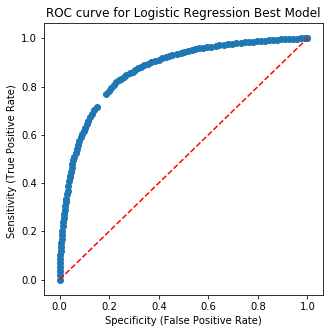

In [0]:
import matplotlib.pyplot as plt

#get roc 
fpr_tpr_df = lr_pipe_2.stages[-1].summary.roc

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.scatter(fpr_tpr_df.select('FPR').collect(),
         fpr_tpr_df.select('TPR').collect())
plt.xlabel('Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate) ')
plt.title('ROC curve for Logistic Regression Best Model')
display()

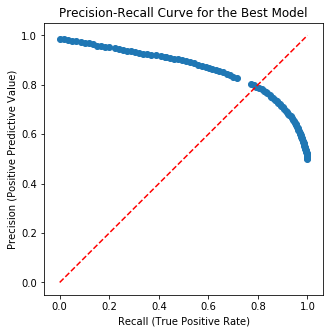

In [0]:
import matplotlib.pyplot as plt

pr_rc_df = lr_pipe_2. stages[-1].summary.pr

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.scatter(pr_rc_df.select('recall').collect(),
         pr_rc_df.select('precision').collect())
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.title('Precision-Recall Curve for the Best Model')
display()

##### Alternate way

In [0]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

thresholds = np.linspace(0,1,100)
fpr1 = []
tpr1 = []
ppv1 = []

for t in thresholds:
  lr_pipe_2.stages[-1].setThreshold(t)
  predictions = lr_pipe_2.transform(testing_df).select(['prediction','target'])
  pl = predictions.select(['prediction','target']).withColumn('label',F.col('target').cast(FloatType())).orderBy('prediction')
  pl = pl.select(['prediction','label'])
  confusionMatrix = MulticlassMetrics(pl.rdd.map(tuple)).confusionMatrix().toArray()
  fpr1.append(confusionMatrix[1][0]/(confusionMatrix[1][0]+confusionMatrix[1][1]))
  tpr1.append(confusionMatrix[0][0]/(confusionMatrix[0][0]+confusionMatrix[0][1]))
  ppv1.append(confusionMatrix[0][0]/(confusionMatrix[0][0]+confusionMatrix[1][1]))

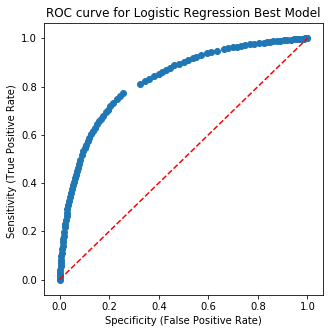

In [0]:
#ROC Curve
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.scatter(fpr1,tpr1)
plt.xlabel('Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate) ')
plt.title('ROC curve for Logistic Regression Best Model')
display()

ROC Curves summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds. Precision-Recall 
curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds. ROC curves 
are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets.

Sensitivity in ROC Curve and Recall in PR Curve are same which is equal to True Positive Rate = True Positive/(True Positive + False Negative)

Specificity in ROC Curve is False Positive Rate = False Positive/(True Negative + False Positive).

Precision in PR Curve is Positive Predictive Value = True Positives / (True Positives + False Positives)